<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/IA353/EF2/Q6P2_NLTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 2

## Predição de séries temporais empregando vários tipos de modelos
#### Parcialmente baseado em https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
## Caso de estudo: Série temporal estacionária e não-linear

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Samuel Borges Ferreira Gomes <br>

### 6.1. Importações e definições

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat

# Specifi imports
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Steps")
    plt.ylabel("Time Series Values")
    plt.title("Sunspots Time Series")
    plt.grid(True)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


### 6.2. Carregando a base de dados e apresentando sua composição

In [2]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

series = np.loadtxt("/content/nlts.txt", dtype='f', delimiter=',')
series = series/15
series = series - np.mean(series)
print(series)

[-0.86525667 -0.9468028  -0.99788886 ... -0.12370616  0.30464625
 -0.1738807 ]


### 6.3. Exibindo o comportamento temporal da série não-linear

Text(0, 0.5, 'Valor da série')

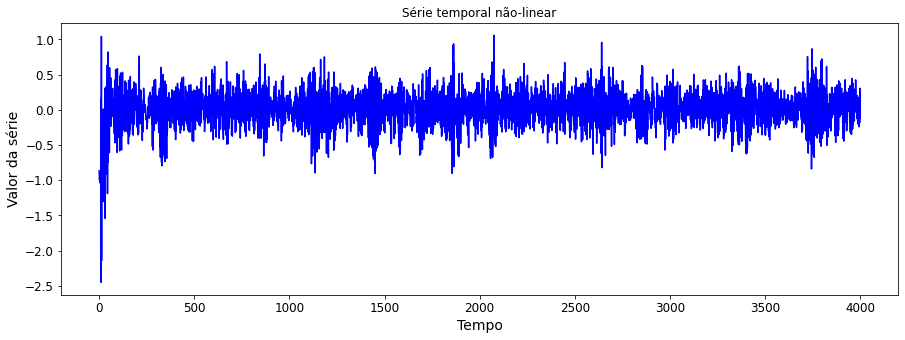

In [3]:
plt.figure(figsize=(15, 5));
plt.plot(series, color='blue', label='open')
plt.title('Série temporal não-linear')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')

### 6.4. Preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste

In [4]:
# function to create train, validation, test data given stock data and sequence length
def load_data(series, seq_len):
    data_raw = np.array(series) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P2_x_train.txt', x_train)
    np.savetxt('Q6P2_y_train.txt', y_train)
    np.savetxt('Q6P2_x_valid.txt', x_valid)
    np.savetxt('Q6P2_y_valid.txt', y_valid)
    np.savetxt('Q6P2_x_test.txt', x_test)
    np.savetxt('Q6P2_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
seq_len = 10 # Número de atrasos a serem considerados
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(series, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3191, 10)
y_train.shape =  (3191, 1)
x_valid.shape =  (399, 10)
y_valid.shape =  (399, 1)
x_test.shape =  (399, 10)
y_test.shape =  (399, 1)


### 6.5. Visualização do comportamento da série temporal de teste

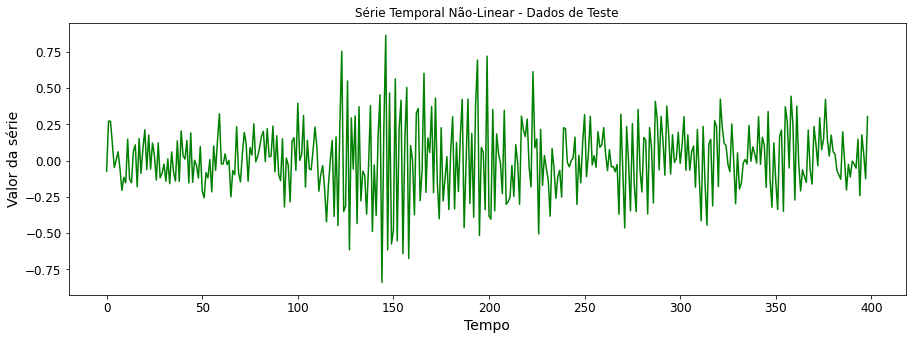

In [5]:
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='green')
plt.title('Série Temporal Não-Linear - Dados de Teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.show()

### 6.6. Sintetizando um preditor linear

In [6]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[ 0.27299142  0.03401006 -0.18766307 -0.33875786  0.05451361  0.15593558
  0.22825877  0.44130719  0.05621329 -0.2540271   0.        ]


#### 6.6.1. Visualização do desempenho do preditor linear

In [7]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
0.043909087273997685
EQM final de validação após o término do treinamento - Preditor Linear
0.031301683631628635
EQM final de teste após o término do treinamento - Preditor Linear
0.04225981520778723


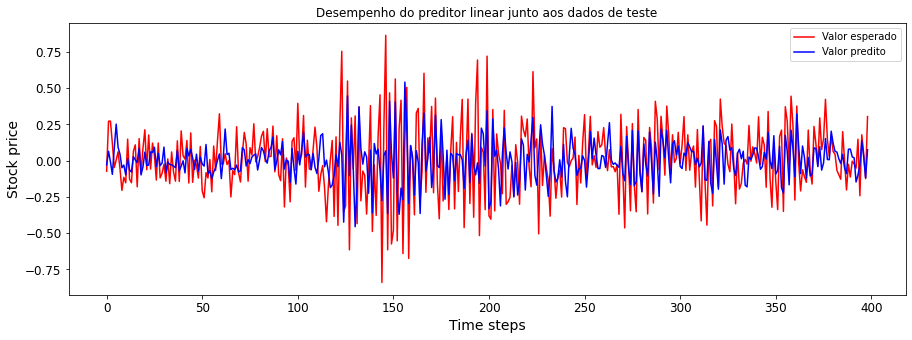

In [8]:
y_pred = X.dot(w)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.7. Sintetizando um preditor não-linear MLP

In [9]:
EPOCHS = 100
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/100
100/100 [==============================] - 1s 4ms/step - loss: 0.0520 - val_loss: 0.0324
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0402
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0368
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0310
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0305
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0336
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0311
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0330
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0326
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0418 - val_lo

In [10]:
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


#### 6.7.1. Carregando o modelo com o menor MAPE para o preditor MLP

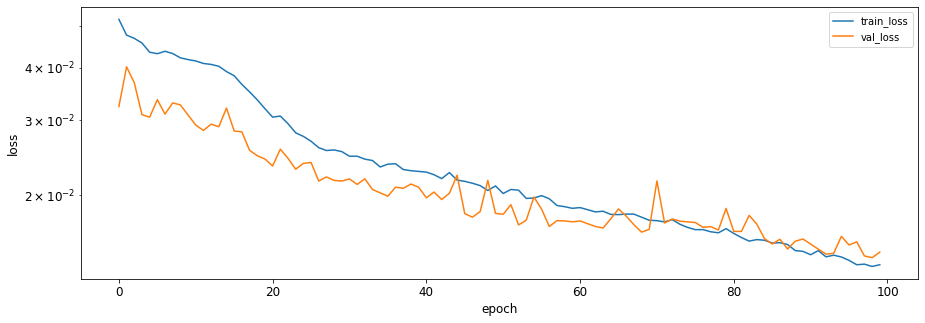

In [11]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.7.2. Visualização do desempenho do preditor MLP

In [12]:
#weights = model_MLP.get_weights()
#print(weights)
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
0.012596771
EQM final de validação após o término do treinamento - Preditor MLP
0.014233273
EQM final de teste após o término do treinamento - Preditor MLP
0.018728139


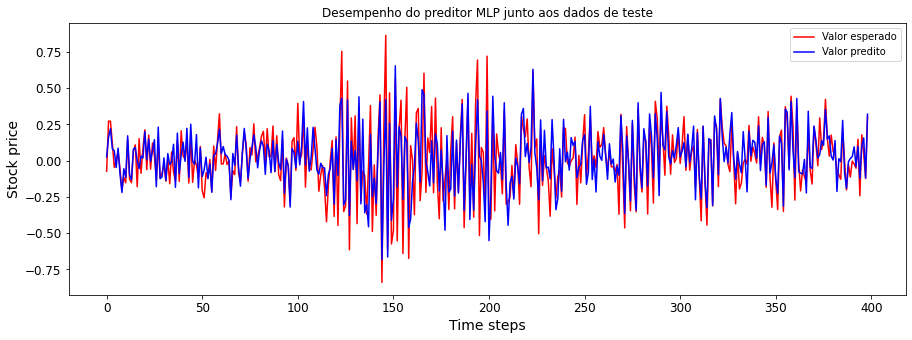

In [13]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.8. Sintetizando um preditor não-linear Simple RNN

In [14]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_RNN1.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN1_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN1.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(3191, 10, 1)
(3191, 1)
(399, 10, 1)
(399, 1)
(399, 10, 1)
(399, 1)
Epoch 1/100
100/100 [==============================] - 2s 8ms/step - loss: 0.0622 - val_loss: 0.0316
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0455 - val_loss: 0.0315
Epoch 3/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0440 - val_loss: 0.0289
Epoch 4/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0429 - val_loss: 0.0282
Epoch 5/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0396 - val_loss: 0.0272
Epoch 6/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0385 - val_loss: 0.0271
Epoch 7/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0373 - val_loss: 0.0255
Epoch 8/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0358 - val_loss: 0.0244
Epoch 9/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0344 - val_loss: 0.0243
Epoch 10/100
100/100 [=

In [15]:
model_RNN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


#### 6.8.1. Carregando o modelo com o menor MAPE para o preditor não-linear Simple RNN

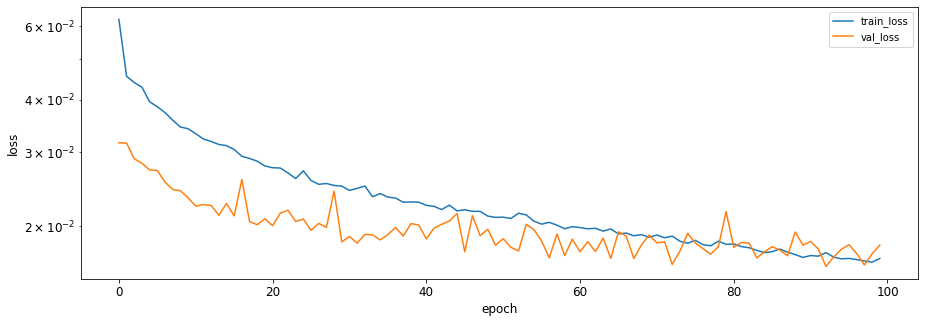

In [16]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN1.load_weights("model_RNN1_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.8.2. Visualização do desempenho do preditor não-linear Simple RNN junto aos dados de teste

In [17]:
print('EQM final de treinamento após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Simple RNN
0.016017541
EQM final de validação após o término do treinamento - Preditor Simple RNN
0.016005317
EQM final de teste após o término do treinamento - Preditor Simple RNN
0.020163467


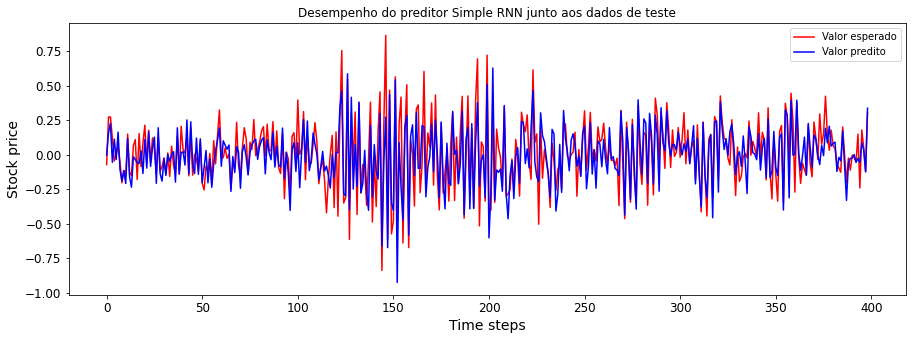

In [18]:
y_pred = model_RNN1.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor Simple RNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.9. Sintetizando um preditor não-linear com bloco LSTM GRU

In [19]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN2 = keras.models.Sequential([
    keras.layers.GRU(seq_len, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(seq_len, return_sequences=True),
    keras.layers.Dense(1)
])

model_RNN2.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN2_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN2.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(3191, 10, 1)
(3191, 1)
(399, 10, 1)
(399, 1)
(399, 10, 1)
(399, 1)
Epoch 1/100
100/100 [==============================] - 5s 17ms/step - loss: 0.0636 - val_loss: 0.0532
Epoch 2/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0632 - val_loss: 0.0536
Epoch 3/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0632 - val_loss: 0.0530
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0630 - val_loss: 0.0530
Epoch 5/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0628 - val_loss: 0.0528
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0629 - val_loss: 0.0536
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0628 - val_loss: 0.0529
Epoch 8/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0626 - val_loss: 0.0528
Epoch 9/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0624 - val_loss: 0.0533
Epoch 10/100
1

In [20]:
model_RNN2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          390       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 10)          660       
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


#### 6.9.1. Carregando o modelo com o menor MAPE para o preditor não-linear com bloco LSTM GRU

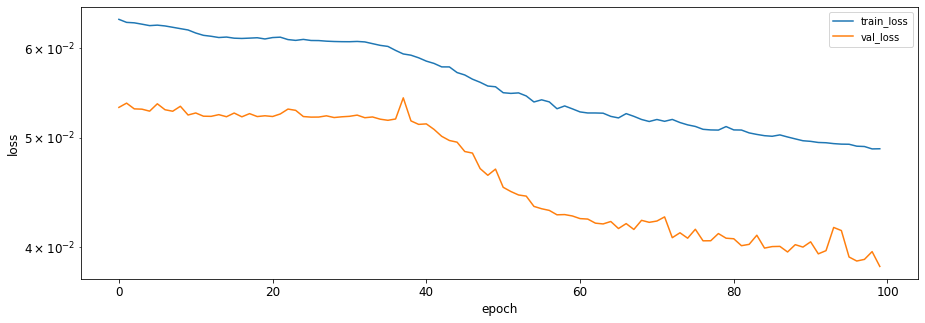

In [21]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN2.load_weights("model_RNN2_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.9.2. Visualização do desempenho do preditor não-linear com bloco LSTM GRU junto aos dados de teste

In [22]:
print('EQM final de treinamento após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_train,y_train)
print('EQM final de validação após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_valid,y_valid)
print('EQM final de teste após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_test,y_test)

EQM final de treinamento após o término do treinamento - Preditor LSTM GRU
100/100 [==============================] - 0s 3ms/step - loss: 0.0484
EQM final de validação após o término do treinamento - Preditor LSTM GRU
13/13 [==============================] - 0s 3ms/step - loss: 0.0385
EQM final de teste após o término do treinamento - Preditor LSTM GRU
13/13 [==============================] - 0s 3ms/step - loss: 0.0484


0.04836989939212799

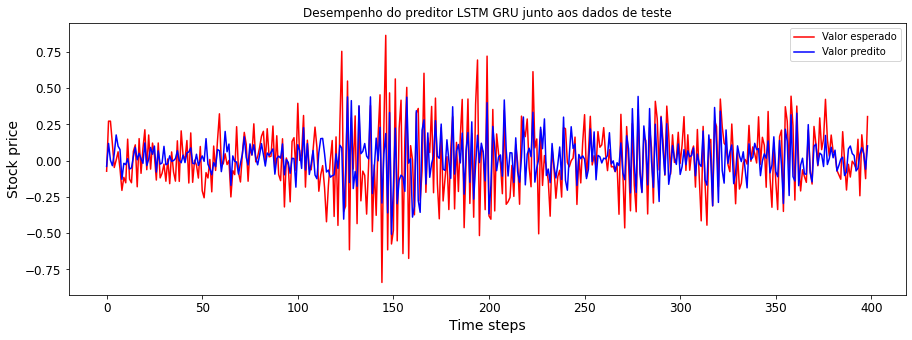

In [23]:
y_pred = model_RNN2.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred[:,seq_len-1], color='blue', label='Valor predito')
plt.title('Desempenho do preditor LSTM GRU junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.10. Sintetizando um preditor não-linear CNN 1D
#### Parcialmente baseado em https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/1_CNN_dilated.ipynb

In [24]:
from keras.layers import Conv1D, Dense, Flatten
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
model_CNN = Sequential()
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(seq_len, 1)))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(1, activation='linear'))
model_CNN.compile(optimizer='Adam', loss='mse')

In [25]:
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 5)             15        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


In [26]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_CNN_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_CNN.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/100
100/100 [==============================] - 16s 8ms/step - loss: 0.0696 - val_loss: 0.0437
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0384
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0355
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0340
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0326
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0313
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0424 - val_loss: 0.0296
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0432 - val_loss: 0.0288
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0279
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0429 - val_l

#### 6.10.1. Carregando o modelo com o menor MAPE para o preditor CNN

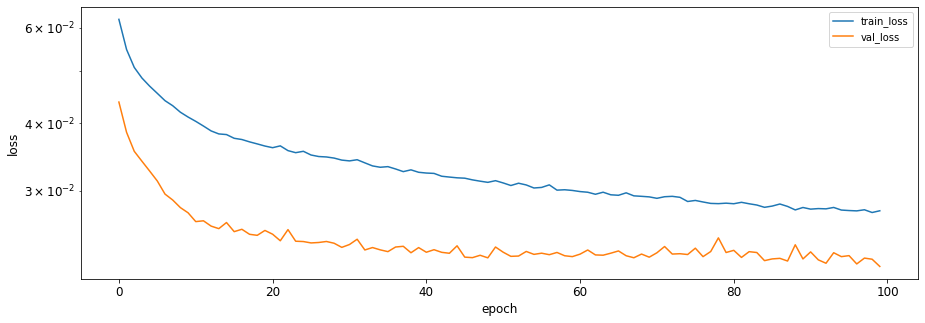

In [27]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_CNN.load_weights("model_CNN_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.10.2. Visualização do desempenho do preditor CNN junto aos dados de teste

In [28]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.026950177
EQM final de validação após o término do treinamento - Preditor CNN
0.021746384
EQM final de teste após o término do treinamento - Preditor CNN
0.029169261


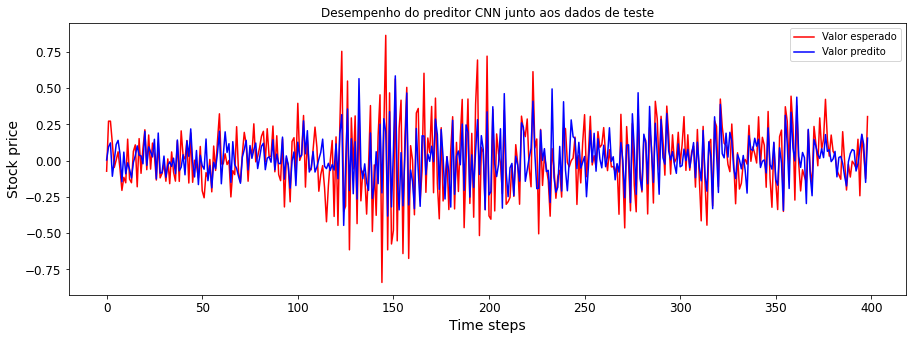

In [29]:
y_pred = model_CNN.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor CNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

## Resultados

### 6.2.1

#### O objetivo desse notebook é comparar diferentes modelos lineares e não-lineares para predição de uma determinada série temporal não-linear. 

#### Os tópicos 6.1 a 6.4 destinam-se a importações dos principais módulos, bem como o carregamento dos dados, escolha da ação desejada, e visualização da série normalizada. Além disso, há o particionamento dos dados para validação cruzada, e o tamanho da janela (sequência observada) é de 10 amostras. Os tópicos seguintes representam um preditor linear/não-linear cada.

#### O tópico 6.5 se limita a visualização do comportamento da série não-linear, especificamente junto aos dados de teste.

#### O tópico 6.6 sintetiza um preditor linear junto a função custo erro quadrático médio, obtido como sendo em torno de 0.042 junto aos dados de teste.

#### O tópico 6.7 sintetiza um preditor não-linear através de um modelo MLP com duas camadas intermediárias com funções de ativação tangente hiperbólica. Treinada em 100 épocas, a rede obteve um erro de 0.018 junto aos dados de teste. A regularização do modelo está sendo feito através de uma parada precoce no treinamento, implementada pela função EarlyStopping

#### O mapeamento produzido por uma rede neural recorrente simples é sintentizado no tópico 6.8. EarlyStopping também é usado a fim de atuar como regularizador do modelo, e sua performance junto aos dados de teste foi um erro médio quadrático de 0.020.

#### O tópico 6.9 também sintetiza uma rede neural recorrente, particularmente com bloco LSTM GRU. Curiosamente, essa sofisticada arquitetura obteve um desempeho parecido com o modelo linear junto aos dados de teste, sendo um erro médio quadrático de 0.048. Esse modelo também usou EarlyStopping como regularizador.

#### Por fim, o último tópico 6.10 sintetiza o mapeamento produzido por uma rede neural convolucional 1D. Com um erro quadrático médio de 0.029 junto aos dados de teste, esse modelo também abordou o EarlyStopping como regularizador.

### 6.2.2

#### Devido a natureza instríseca não-linear do problema, o preditor linear não obtém um bom desempenho comparado a modelos não-lineares.

### 6.2.3


In [33]:
EPOCHS = 100
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/100
100/100 [==============================] - 1s 3ms/step - loss: 0.0520 - val_loss: 0.0324
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0402
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0368
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0310
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0305
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0336
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0311
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0330
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0326
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0418 - val_lo

In [38]:
np.random.seed(43) # not 42, as it would give the first series in the train set
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
# series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:seq_len], series[seq_len:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model_MLP.predict(X[step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, seq_len:]

ValueError: ignored

### 6.2.4

#### Uma opção seria voltar toda a atenção para a amostra mais recente. Além disso, há diferentes técnicas para tentar tornar a séria mais próxima de um processo estacionário, como por exemplo, a técnica de diferenciação, onde são computadas as diferenças entre as observações.